## Final-Project
- Name: Youssef Ayman Mohamed
- Reg.No: 211000348

## Table Of Content

- [Import necessary libraries](#Import-necessary-libraries)
- [Useful Utilities](#Useful-Utilities)
- [Load dataset](#Load-dataset)
- [Model](#Model)
- [Save the model](#Save-the-model)
- [User testing and interface](#User-testing-and-interface)

## Import nessesary libraries

In [77]:
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
#from transformers import AutoTokenizer, MBartForConditionalGeneration
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import dill 

In [78]:
# Load using dill
with open('model.dill', 'rb') as f:
    model = dill.load(f)


## Useful Utilities

In [79]:
class LabeledDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('moussaKam/AraBART') 


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index): # this method should return a single sample at the given index 
        example_id, paragraph, summary = self.data[index]
        inputs = self.tokenizer.encode_plus(paragraph, truncation=True, padding='max_length', max_length=512,
                                            return_tensors='pt') # return_tensors='pt' is used to return PyTorch tensors 
        labels = self.tokenizer.encode_plus(summary, truncation=True, padding='max_length', max_length=110,  
                                            return_tensors='pt') # .encode_plus is used to encode the input and the output 
        return { 
            'input_ids': inputs['input_ids'].squeeze(), # squeeze is used to remove the dimension of size 1 from the shape of the input 
        'attention_mask': inputs['attention_mask'].squeeze(), #
            'labels': labels['input_ids'].squeeze()
        }

In [80]:
def load_labeled_dataset(file_path):
    dataset = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            example_id = data['example_id']
            paragraph = data['paragraph']
            summary = data['summary']
            dataset.append((example_id, paragraph, summary))
    return dataset

In [81]:
#calculate the loss and accuracy of the model
def calculate_loss_and_accuracy(model, data_loader):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch in data_loader: # iterate over the data loader to get the data in batches
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels'] 

        with torch.no_grad(): # disable the gradient calculation to save memory and time
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels) # get the output of the model
            loss = outputs.loss # get the loss of the model
            logits = outputs.logits # get the logits of the model

        total_loss += loss.item() # add the loss to the total loss
        total_samples += input_ids.size(0) # add the number of samples to the total samples
        total_correct += torch.sum(torch.argmax(logits, dim=2) == labels).item() # add the number of correct predictions to the total correct

    return total_loss / total_samples, total_correct / total_samples # return the loss and accuracy of the model


## load dataset

In [82]:
labeled_dataset = load_labeled_dataset('./dataset/labeled_dataset.jsonl')

dataset = LabeledDataset(labeled_dataset)

dataset_size = len(dataset)

dataset_size

c:\Users\youss\.conda\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


154

## Model

The AutoConfig class from the transformers library is used to load the configuration of the 'AraBART' model. This configuration contains various details about the model, such as the number of layers it has, the number of attention heads, etc, By loading this configuration, you can modify it to suit your specific needs before initializing the model.

In [83]:
# Configure the model
model_config = AutoConfig.from_pretrained('moussaKam/AraBART') 
model_config.num_labels = 2 
# the model is being configured for a binary classification task. This means that the model will predict one of two possible outcomes for each input sequence. 

In [84]:
# Create the model
model = AutoModelForSeq2SeqLM.from_pretrained('moussaKam/AraBART', config=model_config)
# the model is being loaded from the 'moussaKam/AraBART' checkpoint and the configuration is being set to the model_config object that we created earlier.

In [85]:
# training parameters for the model for the training process
learning_rate = 1e-5
num_epochs = 12
batch_size = 8

In [86]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# It takes the dataset object that we created earlier and the batch size as input arguments. The shuffle parameter is set to True to shuffle the data before each epoch.

In [87]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #adam optimizer 
criterion = torch.nn.CrossEntropyLoss() #cross entropy loss function

In [88]:
for epoch in range(num_epochs):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad() # Reset the gradients to zero before the backward pass
        input_ids = batch['input_ids'] 
        attention_mask = batch['attention_mask'] 
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss # Compute the loss value
        logits = outputs.logits # The predicted logits

        loss.backward() # Compute the gradients of the loss with respect to the model parameters
        optimizer.step() # Update the model parameters based on the gradients computed in the backward pass "backpropagation"


    # Evaluate the model after each epoch
    model.eval()

In [89]:
# Print the loss and accuracy of the model
loss, accuracy = calculate_loss_and_accuracy(model, data_loader)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Loss: 0.3244, Accuracy: 60.6234


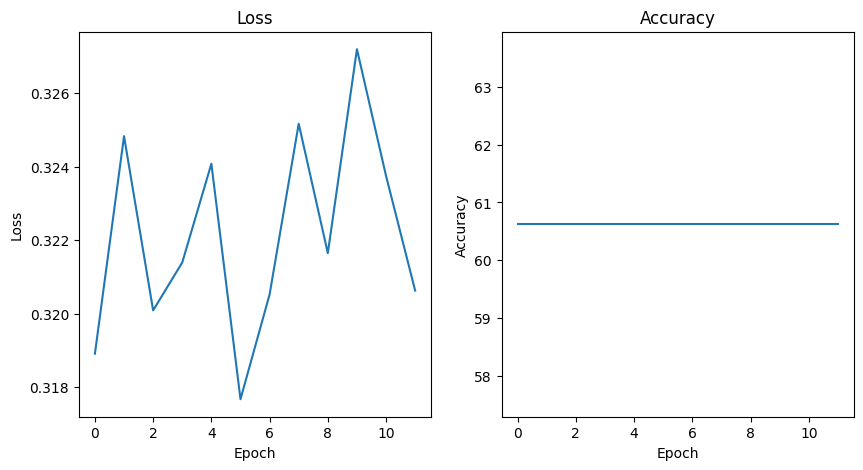

In [90]:
#plot loss and accuracy 
losses = []
accuracies = []
for epoch in range(num_epochs):
    loss, accuracy = calculate_loss_and_accuracy(model, data_loader)
    losses.append(loss)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()





In [91]:
# Save using dill
with open('model.dill', 'wb') as f:
    dill.dump(model, f)

## Save the model


In [92]:
#save to model to device for further use
model.save_pretrained('./Fine-tuned_summarization_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}


## User testing and interface

In [93]:
model_path = './Fine-tuned_summarization_model'
model = AutoModelForSeq2SeqLM.from_pretrained(model_path) # load the model from the saved model path


In [94]:
tokenizer = AutoTokenizer.from_pretrained('moussaKam/AraBART') # load the tokenizer of the model to encode the data to the model format 

c:\Users\youss\.conda\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [95]:
def generate_summary(paragraph): # this function is used to generate a summary for a given paragraph
    # Encode the input paragraph
    inputs = tokenizer.encode_plus(paragraph, truncation=True, padding='max_length', max_length=512, return_tensors='pt') # encode the paragraph to the model format 
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Set the target length of the summary
    paragraph_word_count = len(tokenizer.tokenize(paragraph))
    target_length = int(0.47 * paragraph_word_count)  # Set the target length of the summary to 47% of the input paragraph length 
    # ""CAN BE CHANGED to any percentage you want to be the best for your data""

    model.eval() # Set the model to evaluation mode


    with torch.no_grad(): # Disable gradient calculation to save memory and computation
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=target_length) # Generate the summary
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True) # Decode the generated summary to text

    return summary

In [96]:
# def user_input_prediction():
#     paragraph = input("Enter a paragraph: ")
#     summary = generate_summary(paragraph)                                        # this function is used to get a paragraph from the user and generate a summary for it
#     print("\nGenerated Summary:")
#     print(summary)

In [97]:
# user_input_prediction()

In [98]:
# graido interface
def summarize(paragraph): # this function is used to generate a summary for a given paragraph
    summary = generate_summary(paragraph)
    return summary

iface = gr.Interface(fn=summarize, inputs="text", outputs="text")
iface.launch()



Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
